In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization# This Python 3 environment comes with many helpful analytics libraries installe
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

In [4]:
path = "/kaggle/input/horses-or-humans-dataset/horse-or-human/train"

# Get a list of subdirectories (each subdirectory corresponds to a class)
class_folders = [f.name for f in os.scandir(path) if f.is_dir()]

# Get the number of classes
num_classes = len(class_folders)

# Print the number of classes
print("Number of classes:", num_classes)

Number of classes: 2


In [5]:
img_size = 224
batch_size =100

train="/kaggle/input/horses-or-humans-dataset/horse-or-human/train"
test = "/kaggle/input/horses-or-humans-dataset/horse-or-human/validation"

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming 'fpath' is the path to your dataset and 'batch_size' is defined

datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    validation_split=0.2,
    rotation_range=45,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    subset="training",
    class_mode='categorical',
    batch_size=batch_size
)

valid_gen = datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    batch_size=100,
    subset='validation',
    class_mode='categorical'
)

# For test data
test_gen = ImageDataGenerator(rescale=1/255.).flow_from_directory(
    test,
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for test data
)

Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

In [8]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [9]:
# Create pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(class_count, activation='softmax')
])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Define filepath to save the best model
filepath = 'best_model.h5.keras'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=30,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint,earlystopping]
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5347 - loss: 1.1848
Epoch 1: val_accuracy improved from -inf to 0.51220, saving model to best_model.h5.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 159s 14s/step - accuracy: 0.5315 - loss: 1.1902 - val_accuracy: 0.5122 - val_loss: 2.5722
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4993 - loss: 1.1067
Epoch 2: val_accuracy did not improve from 0.51220
9/9 ━━━━━━━━━━━━━━━━━━━━ 120s 11s/step - accuracy: 0.5008 - loss: 1.0985 - val_accuracy: 0.5122 - val_loss: 0.9777
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5394 - loss: 0.8948
Epoch 3: val_accuracy did not improve from 0.51220
9/9 ━━━━━━━━━━━━━━━━━━━━ 121s 12s/step - accuracy: 0.5368 - loss: 0.8964 - val_accuracy: 0.5122 - val_loss: 0.7055
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4589 - loss: 0.9573
Epoch 4: val_accuracy did not improve from 0.51220
9/9 ━━━━━━━━━━━━━━━━━━━━ 121s 12s/step - accuracy: 0.4610 - loss: 0.9510 - val_accuracy: 0.5122 - v

In [15]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model.h5.keras')

train_score = model.evaluate(train_gen, steps=len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps=len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps=len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 97s 10s/step - accuracy: 0.5004 - loss: 2.6168
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.5123 - loss: 2.5552
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step - accuracy: 0.3400 - loss: 3.6192   
Train Loss:  2.5505685806274414
Train Accuracy:  0.5133820176124573
--------------------
Validation Loss:  2.553877353668213
Validation Accuracy:  0.5121951103210449
--------------------
Test Loss:  2.742053747177124
Test Accuracy:  0.5


In [18]:
model = load_model('best_model.h5.keras')
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 34s 10s/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [17]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[  0 128]
 [  0 128]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       128
           2       0.50      1.00      0.67       128

    accuracy                           0.50       256
   macro avg       0.25      0.50      0.33       256
weighted avg       0.25      0.50      0.33       256



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


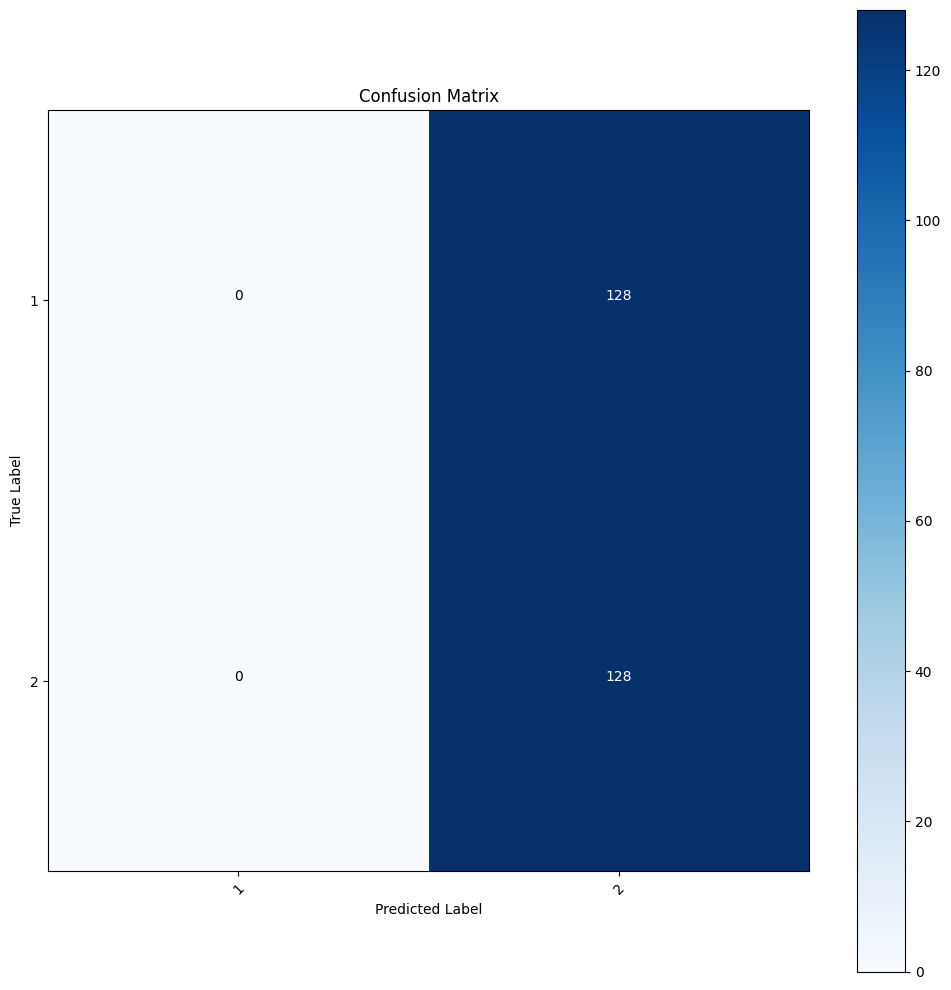

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

target_names = ['1','2']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [21]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_resnet.h5.keras'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint,earlystopping]
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6566 - loss: 0.6953
Epoch 1: val_accuracy improved from -inf to 0.48780, saving model to best_model_resnet.h5.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 134s 12s/step - accuracy: 0.6645 - loss: 0.6836 - val_accuracy: 0.4878 - val_loss: 4.0839
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8149 - loss: 0.4177
Epoch 2: val_accuracy did not improve from 0.48780
9/9 ━━━━━━━━━━━━━━━━━━━━ 133s 11s/step - accuracy: 0.8159 - loss: 0.4162 - val_accuracy: 0.4878 - val_loss: 1.8771
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8596 - loss: 0.3422
Epoch 3: val_accuracy did not improve from 0.48780
9/9 ━━━━━━━━━━━━━━━━━━━━ 116s 11s/step - accuracy: 0.8593 - loss: 0.3424 - val_accuracy: 0.4878 - val_loss: 1.3076
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8759 - loss: 0.2685
Epoch 4: val_accuracy improved from 0.48780 to 0.65366, saving model to best_model_resnet.h5.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 117s 11s/

In [22]:
model= load_model('best_model_resnet.h5.keras')

train_score = model.evaluate(train_gen, steps=len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps=len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps=len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 87s 9s/step - accuracy: 0.7676 - loss: 0.5157
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.6768 - loss: 0.5881
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.7570 - loss: 0.5913
Train Loss:  0.48489323258399963
Train Accuracy:  0.7785888314247131
--------------------
Validation Loss:  0.6050398349761963
Validation Accuracy:  0.6585366129875183
--------------------
Test Loss:  0.45363712310791016
Test Accuracy:  0.81640625


In [24]:
model = load_model('best_model_resnet.h5.keras')
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step
[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1
 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0
 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Confusion Matrix, Without Normalization
[[ 82  46]
 [  1 127]]
              precision    recall  f1-score   support

           1       0.99      0.64      0.78       128
           2       0.73      0.99      0.84       128

    accuracy                           0.82       256
   macro avg       0.86      0.82      0.81       256
weighted avg       0.86      0.82      0.81       256



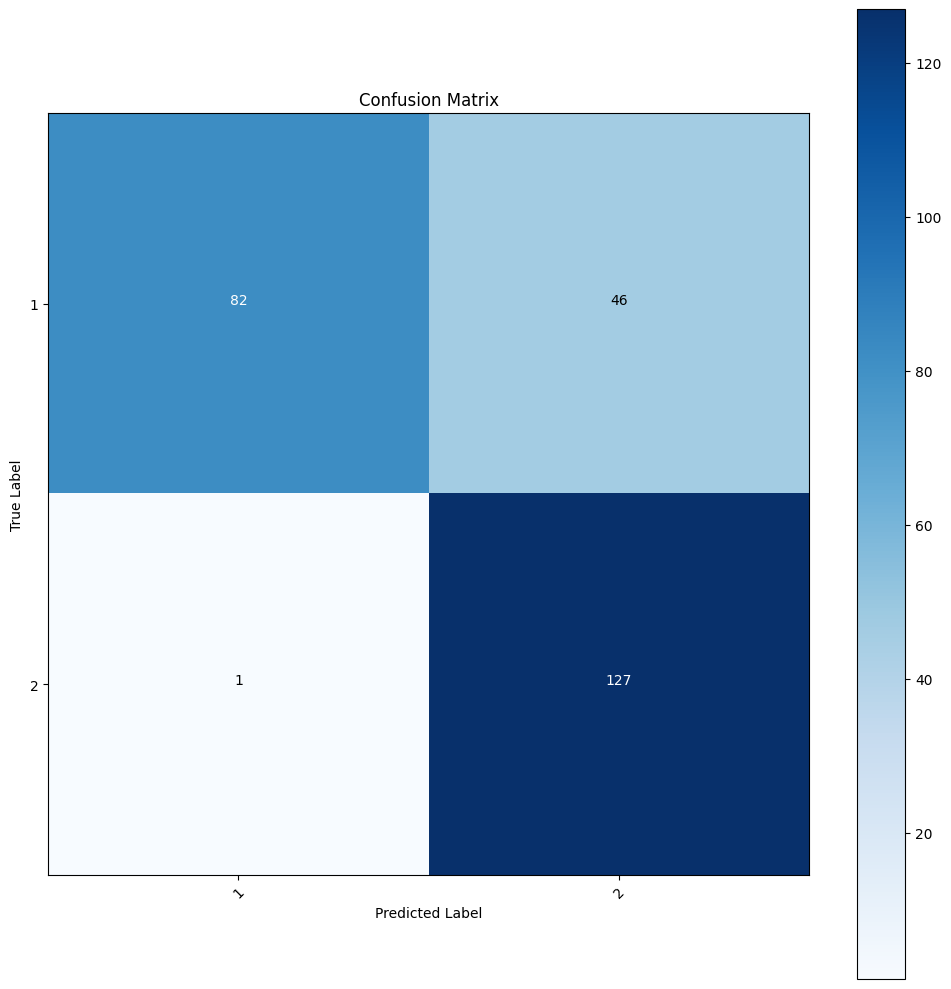

In [25]:
target_names = ['1','2']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [12]:
base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_vgg.h5.keras'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.6948 - loss: 0.6139 
Epoch 1: val_accuracy improved from -inf to 0.67805, saving model to best_model_vgg.h5.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 254s 26s/step - accuracy: 0.7011 - loss: 0.6021 - val_accuracy: 0.6780 - val_loss: 0.5971
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9365 - loss: 0.1822 
Epoch 2: val_accuracy improved from 0.67805 to 0.77561, saving model to best_model_vgg.h5.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 240s 26s/step - accuracy: 0.9375 - loss: 0.1796 - val_accuracy: 0.7756 - val_loss: 0.4097
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9744 - loss: 0.0971 
Epoch 3: val_accuracy improved from 0.77561 to 0.79024, saving model to best_model_vgg.h5.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 235s 25s/step - accuracy: 0.9747 - loss: 0.0963 - val_accuracy: 0.7902 - val_loss: 0.3992
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9936 - loss: 0.0428 
Epoch 4: val_accuracy improved from 0.79024 to 0.

In [13]:
model= load_model('best_model_vgg.h5.keras')

train_score = model.evaluate(train_gen, steps=len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps=len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps=len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 201s 22s/step - accuracy: 0.9860 - loss: 0.0442
3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 12s/step - accuracy: 0.8915 - loss: 0.3178
3/3 ━━━━━━━━━━━━━━━━━━━━ 60s 18s/step - accuracy: 0.9098 - loss: 0.2126
Train Loss:  0.044906824827194214
Train Accuracy:  0.9841849207878113
--------------------
Validation Loss:  0.33943596482276917
Validation Accuracy:  0.8829268217086792
--------------------
Test Loss:  0.16567692160606384
Test Accuracy:  0.9296875


In [14]:
model = load_model('best_model_vgg.h5.keras')
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 61s 18s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Confusion Matrix, Without Normalization
[[110  18]
 [  0 128]]
              precision    recall  f1-score   support

           1       1.00      0.86      0.92       128
           2       0.88      1.00      0.93       128

    accuracy                           0.93       256
   macro avg       0.94      0.93      0.93       256
weighted avg       0.94      0.93      0.93       256



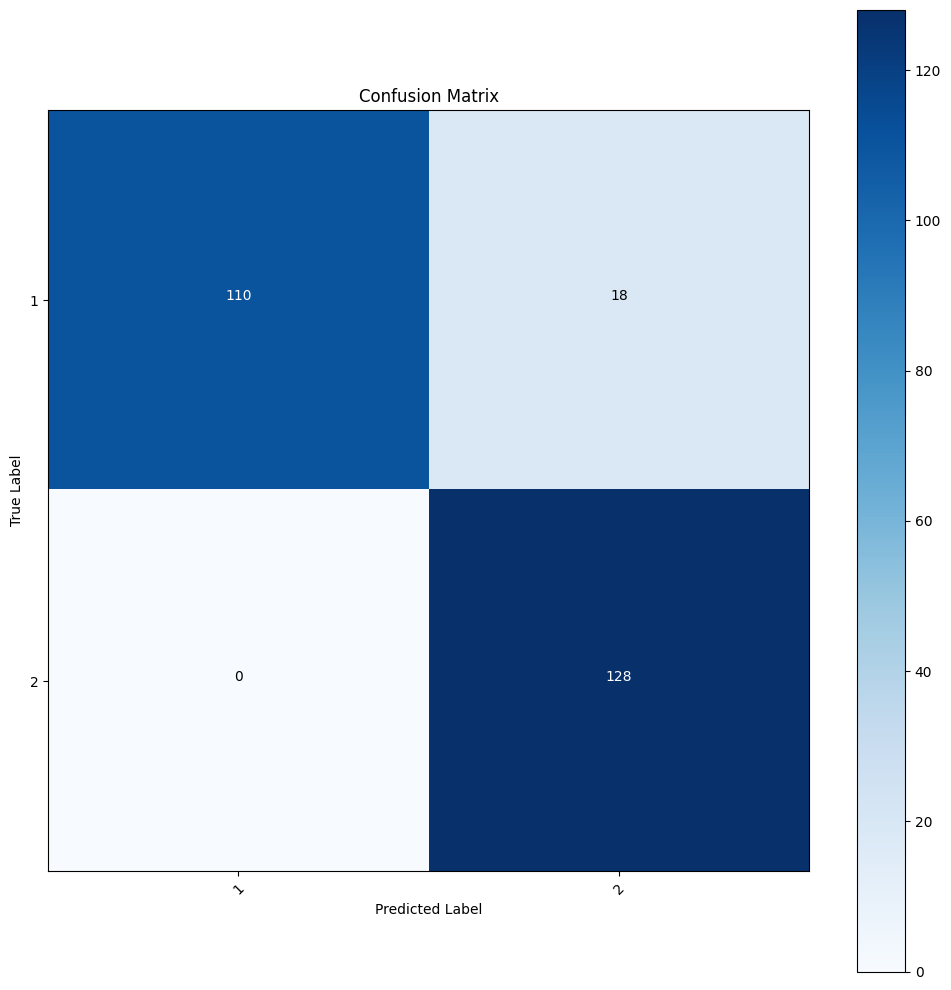

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
target_names = ['1','2']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))